In this project, you will create a classification model for dogs breeds, which should work on any photo and provide a classification outcome for it, assign each photo with a breed label.

The training data is in the folder Breeds_classification/Dataset. You can find your own samples (random images of dogs or other animals) for testing the model outside of the provided data.

The data loading and initial preprocessing is provided below. You are free to do further preprocessing if you think it might be useful.
- Be careful if you are running pytorch on a machine with a gpu or a cpu, you might need to do some adjustments for that.

The main requirement of the project is to achieve average accuracy of 90% or higher. More detailed instructions are provided below.


In [2]:
# visualization
import matplotlib.pyplot as plt

# data manipulations
import numpy as np
import pandas as pd

# pytorch
import torchvision
import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image

# dealing with images from Internet
import requests
from io import BytesIO

# time tracking
from timeit import default_timer as timer

Load the dataset after some standard transforms. Do not forget to adjust the path to the data.

In [ ]:
# transforms for images
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
    ]
)


# datasets
trainset = torchvision.datasets.ImageFolder("./Dataset/train", transform=transforms)
validset = torchvision.datasets.ImageFolder("./Dataset/val", transform=transforms)
testset = torchvision.datasets.ImageFolder("./Dataset/test", transform=transforms)

# batches
batch_size = 128

# loaders for data

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

Visualize some images.

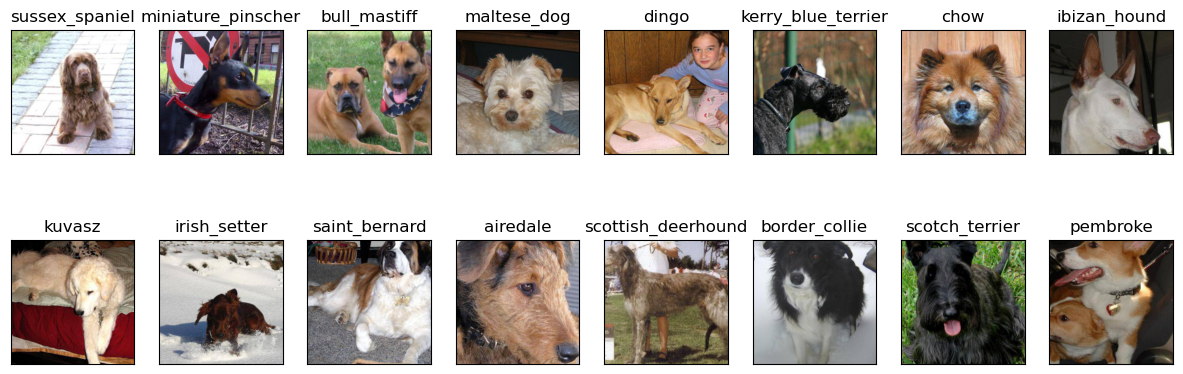

In [ ]:
images, labels = next(iter(trainloader))
images, labels = images.numpy(), labels.numpy()


fig = plt.figure(figsize=(15, 5))

for i in range(int(batch_size / 8)):
    ax = fig.add_subplot(2, int(batch_size / 16), i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray")
    ax.set_title(trainset.classes[labels[i]])

In [5]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  50
number of validation batches :  6
Size of test batches :  7


In [6]:
print("Classes : ", trainset.classes)

Classes :  ['afghan_hound', 'african_hunting_dog', 'airedale', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'brabancon_griffon', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'entlebucher', 'flat-coated_retriever', 'german_shepherd', 'german_short-haired_pointer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'irish_water_spaniel', 'irish_wolfhound', 'japanese_spaniel', 'keeshond', 'kerry_blue_terrier', 'komondor', 'kuvasz', 'labrador_retriever', 'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese_dog', 'mexican_hairless', 'miniature_pinscher', 'miniature_

From here on, you are free to run your classification model. 

You can train your own model, and/or use pretrained models. 

Can you achieve accuracy > 90% on all classes? 

The more detailed report you provide on the performance of the models, the more you can improve on your classification. Think of different ways how to visualize and analyze the performance and the accuracy of your model. What is influencing them? How do you measure the performance of your model? Which hyperparameters are critical to improve the performance? How do the performance and accuracy change with the number of training epochs?
Can you apply your model to random images from the internet? 

You can try it on several images from different classes. What happens if you provide an image of other animal? 

In [7]:
# my_gpu = torch.cuda.is_available()

# MPS setup type shi

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using MPS (Metal Performance Shaders)
Device: mps


In [ ]:
# ResNet50 mit Transfer Learning laden
model = models.resnet50(weights='IMAGENET1K_V2')  # Pretrained auf ImageNet

# Alle Layer einfrieren (wir wollen deren Gewichte nicht verändern)
for param in model.parameters():
    param.requires_grad = False

# Nur die letzte Schicht (fc) ersetzen für unsere 93 Klassen
num_classes = len(trainset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # 2048 → 93

# Modell auf MPS schieben
model = model.to(device)

print(f"Modell geladen: ResNet50")
print(f"Anzahl Klassen: {num_classes}")
print(f"Letzte Schicht: {model.fc}")